# Analyze A/B Test Results 

This current notebook is organised into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Recommendation](#recommendation)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

In [6]:
df['landing_page'].nunique()

2

**d.** The proportion of users converted.

In [7]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
wrong_match1 = df.query('group == "treatment" and landing_page != "new_page"')['user_id'].count()
wrong_match2 = df.query('group == "control" and landing_page != "old_page"')['user_id'].count()
wrong_match1, wrong_match2

(1965, 1928)

In [9]:
#inspecting the wrong matches in our df
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

**f.** Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



**a.**Create a new dataset that meets the specifications.  Store the new dataframe in **df2**.

In [11]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
wrong_match_index1 = df.query('group == "treatment" and landing_page != "new_page"').index
wrong_match_index2 = df.query('group == "control" and landing_page != "old_page"').index
df.drop(wrong_match_index1, inplace = True)
df.drop(wrong_match_index2, inplace = True)

df2 = df

In [12]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [1]:
df2['user_id'].value_counts()

**c.** Display the rows for the duplicate **user_id**? 

In [15]:
duplicate_user = df2.query('user_id == 773192')
duplicate_user

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(1899,inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [17]:
pop_convert_rate = df2.converted.mean()

pop_convert_rate

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff =  df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page == "new_page"')['landing_page'].count()/df2.shape[0]

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

> <span style="color: red;">Based on initial assesment of our data, there is no evidence that suggests that the new treatment group users lead to more conversions</span>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<span style="color: red;">$H_0$ : $p_{new}$ - $p_{old}$ <= 0</span>


<span style="color: red;">$H_1$ : $p_{new}$ - $p_{old}$ > 0</span>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
p_new = pop_convert_rate
p_new 

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [23]:
p_old = pop_convert_rate
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [24]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [28]:
p_new2 = new_page_converted.mean()
p_old2 = old_page_converted.mean()

p_new2 - p_old2

-0.00055300871578534139


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what is expected?<br><br>

Also, we use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


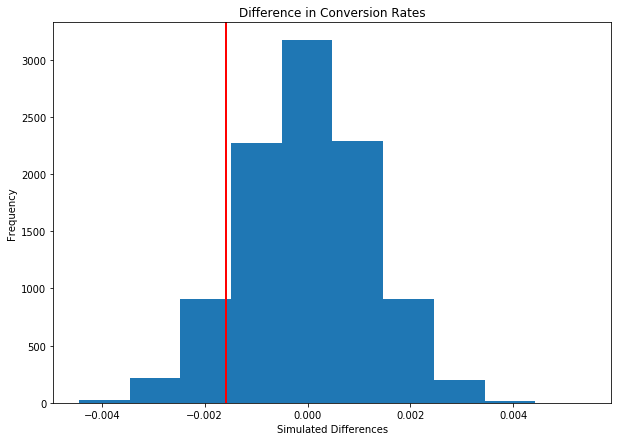

In [30]:
p_diffs = np.array(p_diffs)
plt.figure(figsize=(10,7))
plt.hist(p_diffs)
plt.title("Difference in Conversion Rates")
plt.ylabel('Frequency')
plt.xlabel('Simulated Differences');
plt.axvline(obs_diff,color='r', linewidth=2);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
(p_diffs > obs_diff).mean()

0.90139999999999998

**k.** Explaining the calculated value in **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

>  - <span style="color: red;">The value calculated is called the P value - If $H_0$ is true, the probablity of obtaining the observed statistic or an etreme value in favour of the $H_1$.</span>

>  - <span style="color: red;">The P value calculated suggests that the statistic(obs_diff) is likely from the $H_0$. In order words, the threshold for a type one error is 5% and since our P value is greater than the error threshold, $H_0$ remains valid.</span>





**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [50]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---



In [33]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([convert_new,convert_old])
nobs_array = np.array([n_new,n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array,nobs_array,alternative ='larger' )
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

>   - <span style="color: red;">The P value calculated using the inbuilt method agrees with previous approach where the calculated P value is above a type 1 error threshold(${\alpha}$). Hence, there isn't a significant evidence to reject the $H_0$.</span>

>   - <span style="color: red;">The Z score value agrees that we fail to reject the $H_0$. Having seen that the $Z_{score}$ < $Z_{\alpha}$.</span>

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

> <span style="color: red;">Logistic Regression</span>.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept'] = 1
df2[['other_page','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,other_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate the regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-20 08:58 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [37]:
1/np.exp(-0.0150)

1.0151130646157189

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

- <span style="color: red;">The P value associated with ab_page is 0.1899 which agrees with not to reject the $H_0$.</span> 
**   **
  - <span style="color: red;">The $H_0$ of our logistic regression model(LRM) states that none of the explanatory variable(s) have a statistically significant relationship with the response variable("conversion" rate), y. The $H_1$ of our LRM states that there is a statistically significant relationship between conversion rates and the ab_page column. In order words, $H_0:B_1$ $=$ $0$ and $H_1:B_1$ $!=$ $0$.</span>
**   **
  - <span style="color: red;">In comparison to the $H_0$ and $H_1$ in Part II, Part II investigated same outcome as this current section, where insight was derived from our two competing hypothesis with the basis of the difference in the average conversion rate for both idependent variables(groups). In both cases, we fail to reject the $H_0$.</span>  


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

- <span style="color: red;">An advantage of using multiple explanantory variables is the ability to determine the relative influence of one or more explanantory variables to the criterion value.</span>
**          **
- <span style="color: red;">We can't be entirely reliant on one categorical data due to the influence of distribution bias where class distribution have significant difference in share per category. Considering other explanantory variables or a combination of explanatory variables will suffice. However, it is important to pay attention to the presence of Multicollinearity amongst predictor variables.</span>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 



In [38]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Join with the df2 dataframe
df_merged = df2.merge(df3,on = 'user_id')

df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,other_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [40]:
# Create the necessary dummy variables
df_merged[[ 'CA','UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,other_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [41]:
logit_mod =sm.Logit(df_merged['converted'],df_merged[['intercept','US','UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-20 08:58 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

In [49]:
#making the summary coefficients interpretable by exponentiating.
np.exp(0.0408), np.exp(0.0507)

(1.0416437559600236, 1.0520072437650141)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

**             **

- <span style="color: red;">Consequently, conversion rates are 1.042 times more likely for users living in Canada as compared to users that live in USA, holding all other variables constant.</span>

- <span style="color: red;">Conversion rates are 1.052 times more likely for users living in Canada as compared to users that live in UK, holding all other variables constant.</span>


**h. Fit your model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 



In [45]:
# Fit your model, and summarize the results
df_merged['UK_new'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_new'] = df_merged['US'] * df_merged['ab_page']

In [46]:
logit_mod =sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','US','UK','UK_new','US_new']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-20 09:02 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
UK_new         0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_new         0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

1. <span style="color: red;">The introduction of the country explanatory variable(s) complements previous findings that there isn't a statiscal significance enough to reject our null hypothesis.</span>

2. <span style="color: red;">All calculated P values present in the summary indicates no significance as they are all higher than the 5% probability threshold of a type 1 error.</span>
**             **
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
**             **
<a id='recommendation'></a>
### Recommendation

> <span style="color: red;">All evidence suggests that keeping the old webpage is the most profitable decision to make. The new webpage simply doesn't outperfrom the exisiting webpage.</span>

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])